<a href="https://colab.research.google.com/github/niels-overby/SRP2021/blob/main/SRP_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Setup

!git clone https://github.com/niels-overby/SRP2021.git

%pip install soundfile

import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
import soundfile
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import os

import sys
sys.path.append('/content/SRP2021/')

from audiotools import utils, processing, spectrum

# helper functions 
def interferringTone(x,fs,freq=2000,level_dB = 65):
    A = utils.from_dB(level_dB)
    xlen = np.max(x.shape)
    
    x_sin = A * np.sin(2*np.pi*freq * np.arange(xlen)/fs)
    
    return x_sin

def interferringNoise(x,fs,SNR = 10):
    x_noise = np.random.randn(*x.shape)
    x_noise, _ = utils.adjustSNR(x,x_noise,SNR)
    
    return x_noise

fatal: destination path 'SRP2021' already exists and is not an empty directory.


# Del 2: Signalbehandling i tids-frekvensdomænet

I forrige øvelse brugte vi en metode kaldet short term fourier transform (STFT) til at analysere et lydsignal i tids-frekvensdomænet. Dette gjordes ved at beregne spektrogrammet ud fra en STFT repræsentation af et signal. Analyse er et vigtig redskab som kan bruge i mange sammenhænge. Et eksempel kunne være tale-til-tekst hvor programmer såsom Siri benytter avanceret machine learning modeller på et spektrogram til at lave tale om til tekst. 

Udover analyse kan STFT også bruges til syntese, hvilket betyder at hvis vi har en tids-frekvensrepræsentation af et signal kan det transformeres tilbage til tidsdomænet. Dette kan benyttes til signalbehandling hvor et tidssignal transformeres til tids-frekvensdomænet hvori det ændres og efterfølgende bliver transformeret tilbage til tidsdomænet.

**Indsæt illustration**

## Frekvensfiltrering

I digital signalbehandling betyder filtrering at man fjerner eller isolerer specifikke frekvenser i et spektrum. Dette kan for eksempelvis bruges i musikproduktion hvor man kan fjerne de høje frekvenser fra bas-guitaren for at få el-guitaren til at lyde renere. Her vil et lavpas-filter bruges på bassen, som lader lave frekvenser passere, men fjerner høje frekvenser.
Et højpasfilter gør det omvendte og lader høje frekvenser passere og de dybe frekvenser bliver fjernet.




In [16]:
#@title 1. Scenario {run: "auto"}
#@markdown Du er i gang med at producere et nummer til dit nye album, og 
#@markdown bassisten bliver ved med at spille mens du er i gang med at optage 
#@markdown vokalen. Brug frekvensfiltrering til at fjerne bassen i mixet.

audioDir = '/content/SRP2021/Audio/'
x1, fs = utils.getAudio(audioDir+"song_bass_bad_mix.wav")
fs = fs*2
x1 = processing.normalize().transform(x1)

display(utils.play(x1,fs))


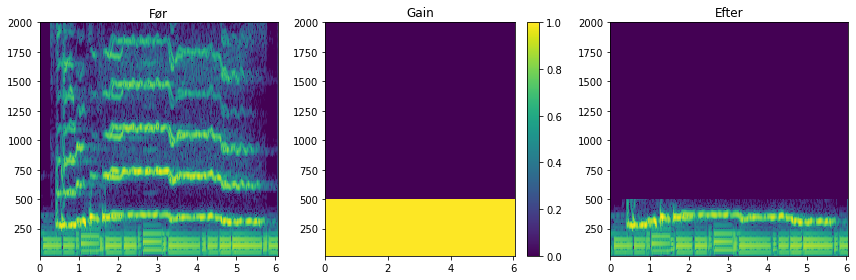

In [17]:
#@title processing: {run: "auto"}
stft = spectrum.STFT(fs=fs,nperseg=4096,nfft=2)
X = stft.transform(x1)

ftype = 'lowpass' #@param ['lowpass','highpass']
fcutoff = 500 #@param {type:"slider", min:0, max:1500, step:1}

mask = np.ones_like(X)
f_idx = np.argmin(stft.f < int(fcutoff))

if ftype == 'highpass':
  mask[:,0:f_idx,:] = 0
elif ftype == 'lowpass':
  mask[:,f_idx::,:] = 0

Y = mask * X

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.pcolormesh(stft.t,stft.f,20*np.log10(np.abs(X[0])),vmin=0,vmax=65)
plt.ylim([20,2000])
plt.title("Før")

plt.subplot(132)
plt.pcolormesh(stft.t,stft.f,np.real(mask[0]))
plt.ylim([20,2000])
plt.colorbar()
plt.title("Gain")


plt.subplot(133)
plt.pcolormesh(stft.t,stft.f,20*np.log10(np.abs(Y[0]+1e-99)),vmin=0,vmax=65)
plt.ylim([20,2000])
plt.title("Efter")

plt.tight_layout()
plt.show()

Enable_audio = True #@param {type:"boolean"}
if Enable_audio:
  y = stft.transform(Y,inv=True)
  display(utils.play(y,fs))


* Analyser spektrogrammet, hvordan ser vokalen ud i forhold til bassen?
* Hvilken type filter skal der bruges til at fjerne bassen fra mixet?
* Hvad viser maske plottet i midten?
* Hvad skal knækfrekvensen indstilles til for at fjerne mest mulig bas og samtidigt bevarer vokal signalet?
* Hvilken ændring skal der til for at fjerne vokalen i stedet for bassen?

## Båndpas og båndstop

En anden type frekvensfiltrering er båndpas og båndstop filtre. Disse filtrer er kombinationer af af lavpas og højpas som tillader at fjerne frekvenser som ligge udenfor et bestemt frekvensbånd, eller fjerne frekvenser som ligger indenfor et bestemt frekvensbånd.

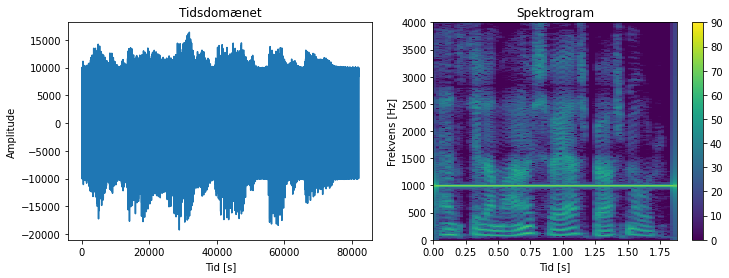

In [4]:
#@title 2. Scenarie: Generende toner i talesignaler
#@markdown I et optaget signal hvor en person taler er der også opfanget en meget høj hyletone. 
#@markdown Analyser spektrogrammet nedenfor og find frem til hvilken frekvens hyletonen har.
audioDir = '/content/SRP2021/Audio/'
audioFiles = list(np.sort([f for f in os.listdir(audioDir) if f.endswith('.wav')]))


x, fs = utils.getAudio(audioDir+audioFiles[-1])
x = processing.normalize().transform(x)
x_tone = interferringTone(x,fs,freq=1000,level_dB=80)
x_m = x+x_tone

stft = spectrum.STFT(fs=fs,nperseg=4096,nfft=2)

Xm = stft.transform(x_m)

display(utils.play(x_m,fs))

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(x_m.T)
plt.title("Tidsdomænet")
plt.xlabel("Tid [s]")
plt.ylabel("Amplitude")

plt.subplot(122)
plt.pcolormesh(stft.t,stft.f,20*np.log10(np.abs(Xm[0])),vmin=0,vmax=90)
plt.ylim([0,4000])
plt.title("Spektrogram")
plt.xlabel("Tid [s]")
plt.ylabel("Frekvens [Hz]")
plt.colorbar()

plt.show()

* Hvilken frekvens har en interfererende tone?
* Brug båndstop filteret til at fjerne hyletonen.



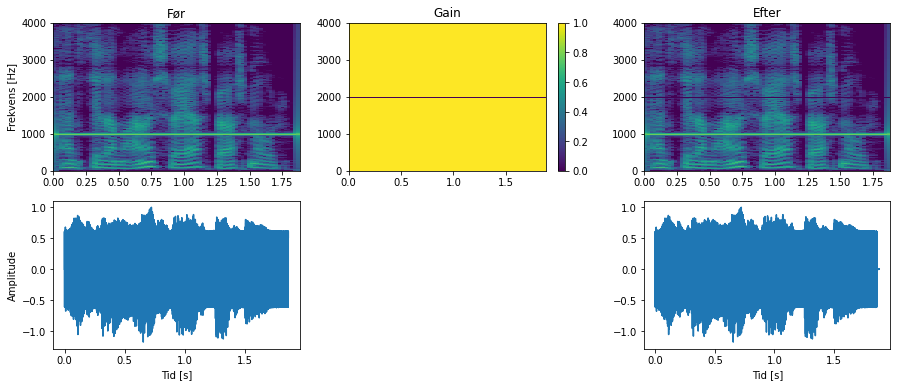

In [13]:
fCenter = 2000 #@param {type:"slider",min:100, max:2000,step:10}
fWidth = 2 #@param {type:"slider",min:1,max:50,step:1}

fCenterIdx = np.argmin(stft.f < fCenter)

mask = np.ones_like(Xm)

mask[:,fCenterIdx-fWidth:fCenterIdx+fWidth,:] *= 0

Ym = mask * Xm

plt.figure(figsize=(15,6))

plt.subplot(231)

plt.pcolormesh(stft.t,stft.f,20*np.log10(np.abs(Xm[0]+1e-99)),vmin=0,vmax=90)
plt.ylim([0,4000])
plt.title("Før")
plt.ylabel("Frekvens [Hz]")

plt.subplot(232)

plt.pcolormesh(stft.t,stft.f,(np.abs(mask[0]+1e-99)))
plt.colorbar()
plt.ylim([0,4000])
plt.title("Gain")

plt.subplot(233)
plt.pcolormesh(stft.t,stft.f,20*np.log10(np.abs(Ym[0]+1e-99)),vmin=0,vmax=90)
plt.ylim([0,4000])
plt.title("Efter")


y = stft.transform(Ym,inv=True)

display(utils.play(y,fs))

plt.subplot(236)
t = np.arange(len(y.T))/fs
plt.plot(t,y.T/x_m.max())
plt.xlabel("Tid [s]")

plt.subplot(234)
t = np.arange(len(x_m.T))/fs
plt.plot(t,x_m.T/x_m.max())
plt.ylabel("Amplitude")
plt.xlabel("Tid [s]")


plt.show()

* Hvad er forskellen på dette type filter og de filtre vi havde i forrige opgave?
* Hvordan lyder talesignalet efter tonen er fjernet?
* Hvordan lyder signalet hvis båndstop filteret er for bredt? (prøv at sætte den så højt som muligt)
* Hvorfor kan vi ikke fjerne frekvensen hvis vi sætter båndstop filteret for smalt? Og hvad skulle der ændres ved STFTen for at kunne fjerne helt specifikke frekvenser? (hint: se ekstra delen i forrige introduktions dokumentet)